# Titanic Using SVM - Kaggle Competition

Author: Szymon Pawłowski\
Date: 10.01.2021r.

# Kaggle Titanic Competition
It is one of the first challenges every ML beginner should dive in. \
In this competition the main goal is to predict which passengers survived the Titanic shipwreck \
using given data and creating a ML model. Here the SVM is used for prediction. 

# The data
The data has been split into two groups: training set and test set. Columns they contain:
* Survival - did passenger survive - 0=no, 1=yes
* Pclass - ticket class - 1=1st, 2=2nd, 3=3rd
* Name 
* Sex - sex - m/f 
* Age - age in years
* Sibsp - number of siblings / spouses aboard the Titanic 
* Parch - number of parents / children aboard the Titanic 
* Ticket - ticket number 
* Fare - passenger fare
* Cabin - cabin number 
* Embarked - port of embarkation - C=Cherbourg, Q=Quennstown, S=Southampton

# Libraries

In [85]:
import pandas as pd
import numpy as np
from numpy import percentile
import random
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import norm, skew

# Loading data and first sight into it

In [2]:
#Loading data
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [3]:
#Combining into one data frame
df = pd.concat([train,test])

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


We can see that Cabin has only 295 non-null observations from 1309. It is too hard to handle those NA's so we will have remove this predictor (either way it was also hard to get information from it). What is more, we need to change object types into binary classification. From Name we can extract special titles which can improve our model. What is more, from SibSp and Parch we can get information about family size and categorize it. Let's see what our data say to us. For that we will exclude PassengerId and Cabin

In [4]:
df1 = df.drop(["PassengerId","Cabin","Ticket"],axis=1)

In [5]:
obj_cols = list(df1.select_dtypes("object").columns)

In [8]:
cont_cols = list(df1.select_dtypes(["float64","int64"]).columns)

# Exploratory Data Analysis (EDA)

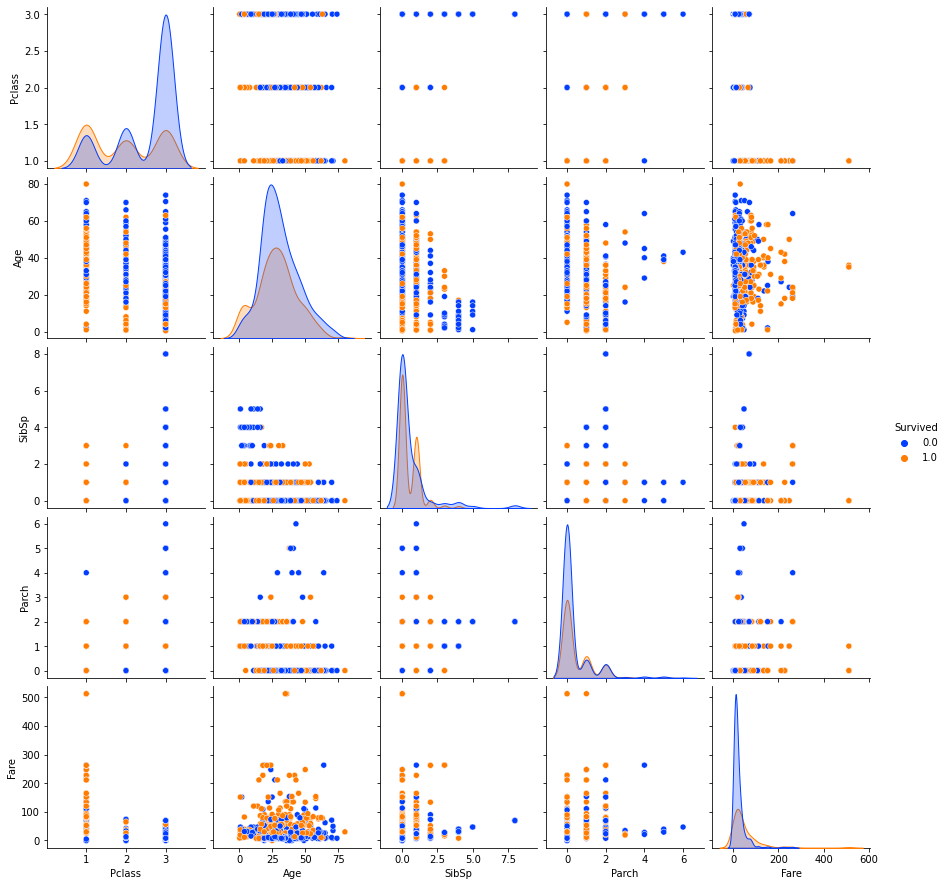

In [10]:
sns.pairplot(df1[cont_cols], hue="Survived", dropna=True,palette="bright")
plt.show()

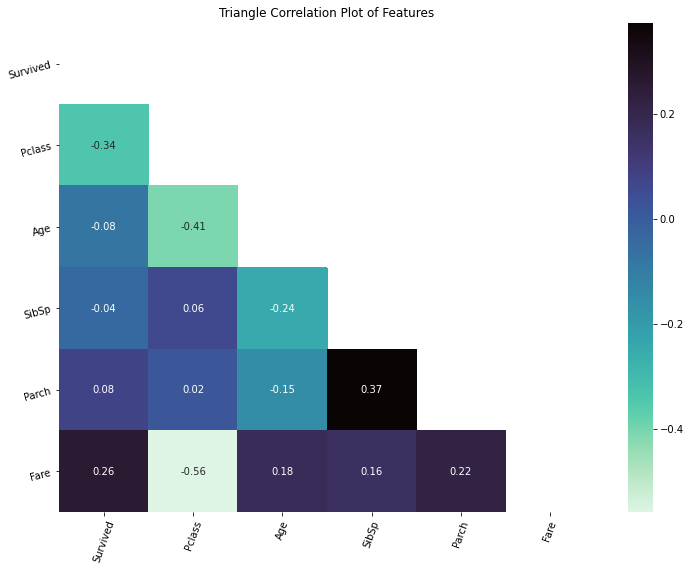

In [20]:
#Heatmap of Correlation for continous variables
cm = df1[cont_cols].corr()
mask = np.triu(np.ones_like(cm, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 9))
g1 = sns.heatmap(cm,cmap='mako_r',fmt='.2f', annot=True, mask=mask)
g1.set_xticklabels(g1.get_xticklabels(),rotation=70,fontsize=10)
g1.set_yticklabels(g1.get_yticklabels(),rotation=15,fontsize=10)
plt.title("Triangle Correlation Plot of Features")
plt.show()

We can notice that:
* Fare is positively correlated with Survived
* Parch and SibSp are highly correlated with Fare
* Survived and Pclass are negatively correlated \
Correlation between rest of the variables is closely to 0 but we will get back to it after some features engingeering. 

**Pclass**

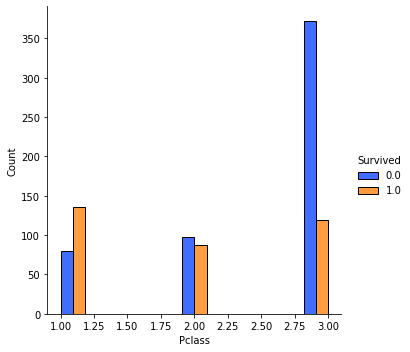

In [13]:
sns.displot(df1, x="Pclass", hue="Survived", multiple="dodge",palette="bright")
plt.show()

We see that in the 1st class there were more survivors and that in the 3rd class we have the opposite situation. Probably those in the first class are better situated and constructed. They might be placed nearby rescue cabins. This variable might be valuable predictor.

**Sex**

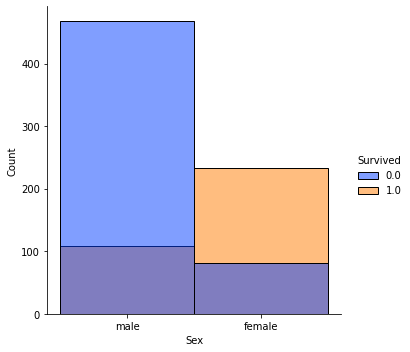

In [14]:
sns.displot(df1, x="Sex", hue="Survived", palette="bright")
plt.show()

Most of the survivors were females. This is a well-known fact that women with children are in the first place to be saved.

**Age**

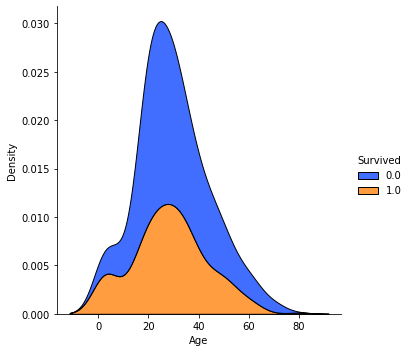

In [15]:
sns.displot(df1, x="Age", hue="Survived",kind="kde", palette="bright",multiple="stack")
plt.show()

Because of the low correlation it is hard to tell something valuable. Most survivors were between age of 20 and 30, similarly the non-survivrors. Later we will try to categorize age and check out if we can get more informations.

**Fare**

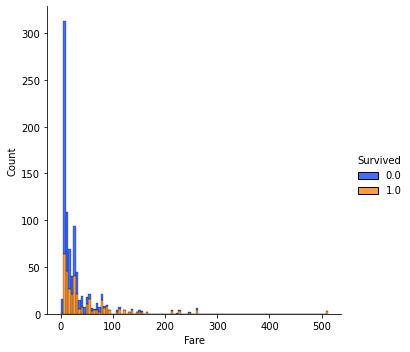

In [16]:
sns.displot(df1, x="Fare", hue="Survived",palette="bright",multiple="stack")
plt.show()

We can notice that most of non-survivors are in the range of low Fare. Survivors are more spreaded and probably there is also an outlier. The less is the charge the less survivors comparing to non-survivors. It might be caused with a fact that well paid cabins could be more durable or be placed closer to rescue boats.

**Embarked**

In [17]:
df1['Embarked'].fillna(random.choice("SQC"), inplace=True) #getting rid of 2 NA's by random choice

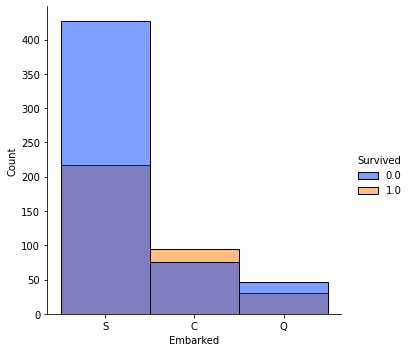

In [18]:
sns.displot(df1, x="Embarked", hue="Survived", palette="bright")
plt.show()

As we can see in Queenstown or Southampton most Fares are in the low interval while in the Cherbourg we may notice that Fares were aswell low as high so the reason standing behind more survivors in Cherbourg are probably better paid cabins.

### Label encoding for object variables to insight the data

In [21]:
labelencoder = preprocessing.LabelEncoder()

In [22]:
df_obj = df1[obj_cols].apply(labelencoder.fit_transform)
df_obj["Survived"] = df1.Survived

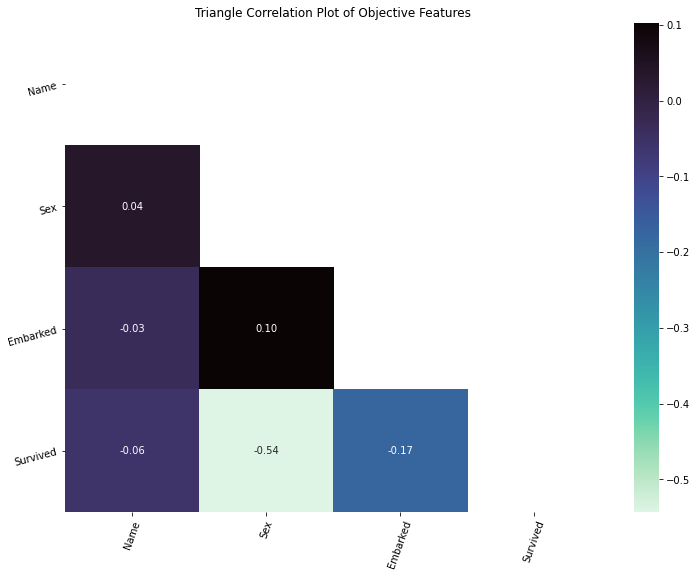

In [25]:
#Heatmap of Correlation for continous variables
cm_obj = df_obj.corr()
mask_obj = np.triu(np.ones_like(cm_obj, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 9))
g2 = sns.heatmap(cm_obj,cmap='mako_r',fmt='.2f', annot=True, mask=mask_obj)
g2.set_xticklabels(g2.get_xticklabels(),rotation=70,fontsize=10)
g2.set_yticklabels(g2.get_yticklabels(),rotation=15,fontsize=10)
plt.title("Triangle Correlation Plot of Objective Features")
plt.show()

Gender and place of embarkation is negatively correlated with Survived target variable.

# Feature Engineering

#### Checking for outliers in continous variables

In [29]:
for col in cont_cols:
        q25, q75 = percentile(df1[col], 25), percentile(df1[col], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outliers = [x for x in df1[col] if x < lower or x > upper]
        if len(outliers) > 0:
            percent = len(outliers)/len(df1[col])*100
            print("Column " + col + " contains %d outliers which is %.2f percent of total set" % (len(outliers),percent))

Column SibSp contains 57 outliers which is 4.35 percent of total set
Column Parch contains 307 outliers which is 23.45 percent of total set


As we see only SibSp and Parch contain outliers but we are going to categorize those variables so we do not need to worry about this

**Sex**

In [48]:
#Changing into binary variable
df1.Sex[df1.Sex=="male"] = -1
df1.Sex[df1.Sex=="female"] = 1

**Embarked**

In [49]:
df1.Embarked[df1.Embarked.isna()==True]=random.choice(["C","Q","S"])
#Changing into binary variable
df1.Embarked[df1.Embarked=="C"] = -1
df1.Embarked[df1.Embarked=="Q"] = 0
df1.Embarked[df1.Embarked=="S"] = 1

**Family Size**

In [50]:
df1["FS"] = df1.Parch + df1.SibSp

df1.FS[df1.FS==1] = -1 #single
df1.FS[(1<df1.FS) & (df1.FS<5)] = 0 #family
df1.FS[df1.FS>=5] = 1 #large family

**Fare**

In [51]:
df1.Fare[df1.Fare.isnull()==True] = df1.Fare.median()


**Titles**

In [52]:
df1["Titles"]=df1.Name.str.extract('([A-Za-z]+)\.',expand=False) #extracting titles

In [53]:
df1.Titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [54]:
df1["TitlesBi"] = df1.Titles
df1.TitlesBi[df1.Titles.isin(["Mr","Mrs"])] = -1
df1.TitlesBi[df1.Titles.isin(["Ms","Miss"])] = 0
df1.TitlesBi[~df1.Titles.isin(["Mr","Mrs","Ms","Miss"])] = 1

In [55]:
#Dropping column Name
df1 = df1.drop(["Name","Titles"],axis=1)

**Age**

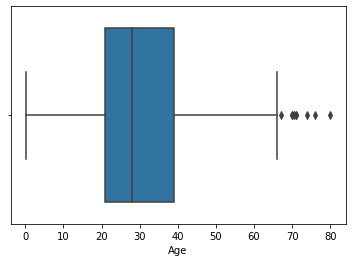

In [56]:
sns.boxplot(df1.Age)
plt.show()

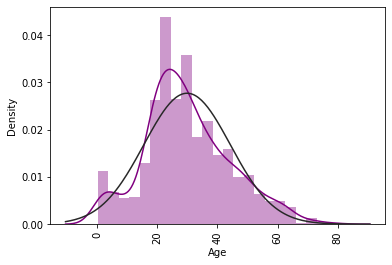

Skewness: 0.407675
Kurtosis: 0.146948


In [57]:
sns.distplot(df1['Age'], color= 'purple',fit=norm);
plt.xticks(rotation=90);
plt.show()

print("Skewness: %f" % df1['Age'].skew())
print("Kurtosis: %f" % df1['Age'].kurt())

We see that our data is skewed and there are outliers so we should not use mean for replacing NA's. Instead we will use mode() which replaces NA's with the most frequent data.

In [58]:
df1.Age[df1.Age.isnull()==True] = df1.Age.median()

In [59]:
df2 = df1.copy()

So we got rid off the missing values. Next, we will change Age and Fare into binary variables but save them as different data frame to see which model will do better.

In [60]:
#Fare
df2.Fare[df2.Fare<=np.quantile(df2.Fare,0.25)] = -1
df2.Fare[(df2.Fare>np.quantile(df2.Fare,0.25)) & (df2.Fare<=np.quantile(df2.Fare,0.75))] = 0
df2.Fare[df2.Fare>np.quantile(df2.Fare, 0.75)] = 1

In [61]:
#Age
df2.Age[df2.Age<=18] = -1 #Child
df2.Age[(df2.Age>18) & (df2.Age <=50)] = 0 #Adult
df2.Age[df2.Age>50] = 1 #Elderly

In [62]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
 8   FS        1309 non-null   int64  
 9   TitlesBi  1309 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 112.5+ KB


In [63]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
 8   FS        1309 non-null   int64  
 9   TitlesBi  1309 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 112.5+ KB


In [45]:
#

Finally we have cleaned up the data. We got rid of the missing values, changed most values into numerical binary variables and got new features like FS or Titles. Now we are going to fit a model and make some predictions!

# Model validation

In [64]:
#Get rid of test data we combined
df_train1 = df1[df1.Survived.isnull()==False]
df_train2 = df2[df2.Survived.isnull()==False]

df_test1 = df1[df1.Survived.isnull()==True]
df_test2 = df2[df2.Survived.isnull()==True]

In [65]:
#splitting train into test and train data
x1 = df_train1.drop(["Survived"],axis=1)
x2 = df_train2.drop(["Survived"],axis=1)

y1=df_train1.Survived
y2=df_train2.Survived

In [66]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2)

In [83]:
#Encoding target variable
lab_enc1 = preprocessing.LabelEncoder()
lab_enc2 = preprocessing.LabelEncoder()

y1_train_e = lab_enc1.fit_transform(y1_train)
y2_train_e = lab_enc2.fit_transform(y2_train)

In [84]:
y1_test = lab_enc1.transform(y1_test)
y2_test = lab_enc2.transform(y2_test)

In [68]:
clf = svm.SVC()

In [69]:
fitting1 = clf.fit(x1_train,y1_train_e)
fitting2 = clf.fit(x2_train,y2_train_e)

In [70]:
y1_pred = clf.predict(x1_test)
y2_pred = clf.predict(x2_test)

In [71]:
print(confusion_matrix(y1_test,y1_pred))
print(classification_report(y1_test,y1_pred))

[[109   0]
 [ 70   0]]
              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76       109
         1.0       0.00      0.00      0.00        70

    accuracy                           0.61       179
   macro avg       0.30      0.50      0.38       179
weighted avg       0.37      0.61      0.46       179



In [72]:
print(confusion_matrix(y2_test,y2_pred))
print(classification_report(y2_test,y2_pred))

[[94 15]
 [20 50]]
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       109
         1.0       0.77      0.71      0.74        70

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



We got really high score of predicting for df2. From this we can conclude that binary variables are affecting in better predictions. Next we will search for the best hyperparameters for our classifier with GridSearchCV and make predictions

## SVM

In [93]:
clf_svm = svm.SVC(probability=True)

In [94]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}

grid_svm = GridSearchCV(clf_svm, param_grid=param_grid_svm)
grid_svm.fit(x2_train,y2_train_e)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

## Random Forest

In [88]:
clf_forest = RandomForestClassifier()

In [89]:
param_grid_forest = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid_forest = GridSearchCV(clf_forest, param_grid=param_grid_forest)
grid_forest.fit(x2_train,y2_train_e)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

## Logistic Regression

In [90]:
clf_log = LogisticRegression()

In [91]:
param_grid_log =  {"C": np.logspace(-4, 4, 10)}


grid_log = GridSearchCV(clf_log, param_grid=param_grid_log)
grid_log.fit(x2_train,y2_train_e)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])})

## Comparison

In [97]:
svm_proba = grid_svm.predict_proba(x2_test)
log_proba = grid_log.predict_proba(x2_test)
forest_proba = grid_forest.predict_proba(x2_test)

In [98]:
false_positive_rate_svm, true_positive_rate_svm, threshold_svm = roc_curve(y2_test, svm_proba[:,1])
false_positive_rate_log, true_positive_rate_log, threshold_log = roc_curve(y2_test, log_proba[:,1])
false_positive_rate_forest, true_positive_rate_forest, threshold_forest = roc_curve(y2_test, forest_proba[:,1])

print('roc_auc_score for SVM: ', roc_auc_score(y2_test, svm_proba[:,1]))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y2_test, log_proba[:,1]))
print('roc_auc_score for Random Forest: ', roc_auc_score(y2_test, forest_proba[:,1]))

roc_auc_score for SVM:  0.8420707732634338
roc_auc_score for Logistic Regression:  0.8500655307994757
roc_auc_score for Random Forest:  0.8644823066841415


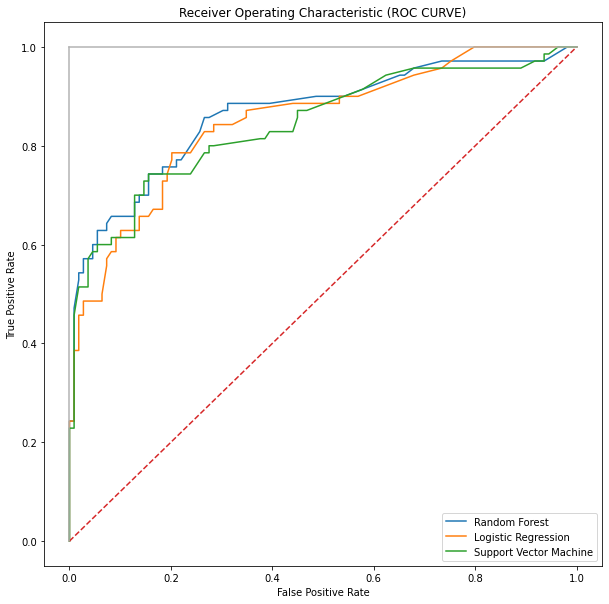

In [99]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic (ROC CURVE)')
plt.plot(false_positive_rate_forest, true_positive_rate_forest, label="Random Forest")
plt.plot(false_positive_rate_log, true_positive_rate_log, label="Logistic Regression")
plt.plot(false_positive_rate_svm, true_positive_rate_svm, label="Support Vector Machine")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [102]:
svm_score = grid_svm.predict(x2_test)
log_score = grid_log.predict(x2_test)
forest_score = grid_forest.predict(x2_test)

In [103]:
print('Classification report for SVM: \n', classification_report(y2_test,svm_score))
print('\nClassification report for Logistic Regression: \n', classification_report(y2_test,log_score))
print('\nClassification report for Random Forest: \n', classification_report(y2_test,forest_score))

Classification report for SVM: 
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       109
           1       0.75      0.70      0.73        70

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179


Classification report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       109
           1       0.73      0.66      0.69        70

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179


Classification report for Random Forest: 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       109
           1       0.77      0.67      0.72        70

    accuracy                           0.79       179
 

# Final predictions using SVM

In [73]:
train_final = df2[df2.Survived.isnull()==False]
test_final = df2[df2.Survived.isnull()==True]

In [74]:
X_train =  train_final.drop("Survived",axis=1)
Y_train = train_final.Survived

X_test = test_final.drop("Survived",axis=1)

In [75]:
Y_train = lab_enc.fit_transform(Y_train)

In [80]:
pipe_steps = [('scaler', StandardScaler()), ('SVMclf', svm.SVC(kernel='rbf'))]

check_params= {
    'SVMclf__C': [0.1, 1, 10, 100, 1000],  
    'SVMclf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

pipeline = Pipeline(pipe_steps)

grid = GridSearchCV(pipeline, check_params, cv=3, n_jobs=-1)

grid.fit(X_train,Y_train)

print("Grid search best params: ", grid.best_params_)

Grid search best params:  {'SVMclf__C': 1, 'SVMclf__gamma': 0.1}


In [81]:
predicted = grid.predict(X_test)

In [82]:
submission = pd.DataFrame({ 'PassengerId': test.PassengerId,
                            'Survived': predicted })
submission.to_csv("submission.csv", index=False)